In [240]:
print(__doc__)

import os
import time
import json
import pickle
import math
import random

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.special import expit
from scipy import stats
from pylab import rcParams
import mplcursors

from sklearn.datasets import load_iris
from sklearn.datasets import load_digits

from sklearn.utils import check_random_state
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

from sklearn import linear_model
from sklearn import semi_supervised
from sklearn import naive_bayes
from sklearn import neighbors
from sklearn import discriminant_analysis
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.utils import check_random_state
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.naive_bayes import GaussianNB

from sklearn import metrics
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score


# pd.options.display.max_rows = 20
pd.options.display.float_format = "{:.1f}".format


Automatically created module for IPython interactive environment


In [241]:
def fetch_data_corona():
    data = pd.read_csv("https://raw.githubusercontent.com/WenxuanHuang/ML-for-COVID-19-dataset/main/all_training.csv", sep=',')
    # Column selection
    df = data.iloc[:,np.r_[3:34]].copy()
    # define row and column index
    col = df.columns
    row = [i for i in range(df.shape[0])]
    # define imputer
    imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')
    # fit on the dataset
    imputer.fit(df)
    # transform the dataset
    df_imputed = imputer.transform(df)
    # convert back to pandas dataframe and rename back to df_normalized
    df = pd.DataFrame(data=df_imputed, index=row, columns=col)
    X = df
    y = data.target    
    # # Recursive feature elimination
    # rdmreg = RandomForestClassifier(n_estimators=100)
    # # Define the method
    # rfe = RFE(estimator=rdmreg, n_features_to_select=10)
    # # Fit the model
    # rfe = rfe.fit(X, y.values.ravel())
    # print(rfe.support_)
    # # Drop columns that failed RFE test
    # col = df.columns[rfe.support_]
    # X = X[col]
    X = X.to_numpy()
    print ('df:', X.shape, y.shape)
    return (X, y)


In [242]:
def fetch_data_iris():
    iris = load_iris()
    X = iris.data.astype('float64')
    y = iris.target
    # print ('Dataset : ', X.shape, y.shape)
    return (X, y)

def fetch_data_mnist():
    mnist = load_digits()
    X = mnist.data.astype('float64')
    y = mnist.target
    # print ('Dataset : ', X.shape, y.shape)
    return (X, y)

In [243]:
class BaseModel(object):

    def __init__(self):
        pass

    def fit_predict(self):
        pass


class SvmModel(BaseModel):

    model_type = 'Support Vector Machine with linear Kernel'
    def fit_predict(self, X_train, y_train, X_val, X_test):
        print ('training svm...')
        self.classifier = SVC(
            kernel='linear', 
            probability=True
            )
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted,
                self.test_y_predicted)

class LogModel(BaseModel):

    model_type = 'Logistic Regression' 
    def fit_predict(self, X_train, y_train, X_val, X_test):
        # print ('training logistic regression...')
        train_samples = X_train.shape[0]
        self.classifier = LogisticRegression(
            # C=50. / train_samples,
            penalty='l2',
            solver='liblinear',
            tol=0.1
            )
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted,
                self.test_y_predicted)


class GausModel(BaseModel):

    model_type = 'Logistic Regression' 
    def fit_predict(self, X_train, y_train, X_val, X_test):
        # print ('training logistic regression...')
        train_samples = X_train.shape[0]
        self.classifier = GaussianNB()
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted,
                self.test_y_predicted)


In [244]:
class TrainModel:

    def __init__(self, model_object):        
        self.accuracies = []
        self.model_object = model_object()        

    def print_model_type(self):
        print (self.model_object.model_type)

    # we train normally and use the probabilities to select the most uncertain samples
    def train(self, X_train, y_train, X_val, X_test):
        print ('Train set:', X_train.shape)
        print ('Validation set:', X_val.shape)
        print ('Test set:', X_test.shape)
        t0 = time.time()
        (X_train, X_val, X_test, self.val_y_predicted,
         self.test_y_predicted) = \
            self.model_object.fit_predict(X_train, y_train, X_val, X_test)
        self.run_time = time.time() - t0
        return (X_train, X_val, X_test)

    # we want accuracy only for the test set
    def get_test_accuracy(self, i, y_test):
        classif_rate = np.mean(self.test_y_predicted.ravel() == y_test.ravel()) * 100
        self.accuracies.append(classif_rate)               
        print('--------------------------------')
        print('Iteration:',i)
        # print('--------------------------------')
        # print('y-test set:',y_test.shape)
        # print('Training run in %.3f s' % self.run_time,'\n')
        print("Accuracy rate is %f " % (classif_rate))    
        # print("Classification report for %s:\n%s\n" % (self.model_object.classifier, metrics.classification_report(y_test, self.test_y_predicted)))
        # print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, self.test_y_predicted))
        print('--------------------------------')


In [245]:
class Normalize(object):
    
    def normalize(self, X_train, X_val, X_test):
        self.scaler = RobustScaler()
        X_train = self.scaler.fit_transform(X_train)
        X_val   = self.scaler.transform(X_val)
        X_test  = self.scaler.transform(X_test)
        return (X_train, X_val, X_test) 
    
    def inverse(self, X_train, X_val, X_test):
        X_train = self.scaler.inverse_transform(X_train)
        X_val   = self.scaler.inverse_transform(X_val)
        X_test  = self.scaler.inverse_transform(X_test)
        return (X_train, X_val, X_test) 

In [246]:
def get_random_samples(initial_samples, X_train_full, y_train_full):

    permutation = np.random.choice(len(X_train_full),initial_samples,replace=False)
    X_train = X_train_full[permutation]
    y_train = y_train_full[permutation]
    X_train = X_train.reshape((X_train.shape[0], -1))

    return (permutation, X_train, y_train)

In [247]:
def log_loss(labels, probs):

    eps = np.finfo(probs.dtype).eps
    probs = np.clip(probs, eps, 1 - eps)
    loss = 0

    for i in range(len(probs)):
        for prob in probs[i]:
            loss -= (labels[i]*np.log(prob))
 
    ll = loss/(len(probs)*1.)

    return ll

In [249]:
class TheAlgorithm(object):

    accuracies = []

    def __init__(self, step, model_object):
        self.step = step
        self.model_object = model_object
        
    def run(self, X_train_full, y_train_full, X_test, y_test, initial_queried, max_queried):

        (permutation, X_train, y_train) = get_random_samples(initial_queried, X_train_full, y_train_full)
        self.queried = initial_queried

        X_val = np.array([])
        y_val = np.array([])
        X_val = np.copy(X_train_full)
        X_val = np.delete(X_val, permutation, axis=0)
        y_val = np.copy(y_train_full)
        y_val = np.delete(y_val, permutation, axis=0)

        normalizer = Normalize()
        X_train, X_val, X_test = normalizer.normalize(X_train, X_val, X_test)
           
        self.clf_model = TrainModel(self.model_object)
        (X_train, X_val, X_test) = self.clf_model.train(X_train, y_train, X_val, X_test)
        active_iteration = 1
        self.clf_model.get_test_accuracy(1, y_test)

        while self.queried <= max_queried-self.step:

            active_iteration += 1
            self.queried += self.step
            (mc_permutation, X_subset, y_subset) = \
                get_random_samples(10, X_val, y_val) # 10 is the subset size
            # print('Indexes in the subset for X_val:', mc_permutation)
            # print ('Subset:', X_subset.shape, y_subset.shape, monte_carlo_permutation.shape)
            # print ('Train:', X_train.shape, y_train.shape, permutation.shape)
            cand_probs = self.clf_model.model_object.classifier.predict_proba(X_subset)
            # print("structure of cand_probs:", cand_probs)
            
            # print("Class of model:", self.clf_model.model_object.classifier.classes_)

            utils = []

            for i in range(len(X_subset)):
                new_train_X = X_train
                new_train_X = np.append(new_train_X, [X_subset[i]], axis=0)
                util = 0
                new_label_y = np.random.randint(0, 9, size=len(X_subset))
                # new_label_y = np.random.choice([0, 1], size=len(X_subset),)
                # print("Newly assigned labels:", new_label_y)
                # To-do: random.randint is too inefficient
                for label in new_label_y:
                    new_train_y = y_train
                    new_train_y = np.append(new_train_y, label)
                    # print('Monte_carlo training set X:', new_train_X)
                    # print('Monte_carlo training set y:', new_train_y)
                    new_classifier = self.clf_model.model_object.classifier
                    new_classifier.fit(new_train_X, new_train_y)
                    new_probs = new_classifier.predict_proba(X_subset)
                    # new_preds = new_classifier.predict(X_subset)
                    # print("structure of new_probs:", cand_probs)
                    # util for log_loss
                    util += cand_probs[i][label] * log_loss(y_subset, new_probs)
                    # util for mse_loss
                    # util += cand_probs[i][label] * mse_loss(y_subset, new_preds)

                utils.append(util)
                
            uis = np.argsort(utils)
            # need to check validity
            # print ('Monte-carlo selected indexes:', uis)
  

            X_uncertain = [X_subset[i] for i in uis[:self.step]]
            y_uncertain = [y_subset[i] for i in uis[:self.step]]
            uncertain_samples = mc_permutation[uis[:self.step]]
            # print ('Monte-carlo selected indexes:', uncertain_samples)
            # print ('Monte-carlo selected samples:', X_uncertain)
            # print ('Monte-carlo selected outcomes:', y_uncertain)

            X_train, X_val, X_test = normalizer.inverse(X_train, X_val, X_test)   
            X_train = np.concatenate((X_train, np.array(X_uncertain)))
            y_train = np.concatenate((y_train, np.array(y_uncertain)))

            X_val = np.delete(X_val, uncertain_samples, axis=0)
            y_val = np.delete(y_val, uncertain_samples, axis=0)

            normalizer = Normalize()
            X_train, X_val, X_test = normalizer.normalize(X_train, X_val, X_test)               

            (X_train, X_val, X_test) = self.clf_model.train(X_train, y_train, X_val, X_test)
            self.clf_model.get_test_accuracy(active_iteration, y_test)

        return self.clf_model.accuracies

In [250]:
def pool_experiment(model,max_queried,initial_queried,step):

    (X, y) = fetch_data_mnist()

    # print("min/max:",min(y),max(y))

    kf = KFold(n_splits=4)
    for train_index, test_index in kf.split(X):
        X_train_full, X_test = X[train_index], X[test_index]
        y_train_full, y_test = y[train_index], y[test_index]
        
    act_alg = TheAlgorithm(step, model)
    accuracies = act_alg.run(X_train_full,y_train_full,X_test,y_test,initial_queried,max_queried)

    (permutation, X_train_selected, y_train_selected) = get_random_samples(initial_queried, X_train_full, y_train_full)
    original_accuracies=[]
    classifier_original = LogisticRegression(
            penalty='l2',
            solver='liblinear',
            tol=0.1
            )
    x_axis = []
    for i in range(initial_queried-1,max_queried,step):
        classifier_original.fit(X_train_selected[:i+1], y_train_selected[:i+1])
        y_pred_original = classifier_original.predict(X_test)
        original_accuracies.append(accuracy_score(y_test, y_pred_original)*100)
        x_axis.append(i+1)
    print("accuracies",accuracies)
    print("nonactive_accuracies",original_accuracies)
    plt.plot(x_axis, accuracies, 'r',label='active')
    plt.plot(x_axis, original_accuracies, 'blue',label='non-active')
    plt.legend()
    plt.xlabel('Sample Size')
    plt.ylabel('Accuracy')
    plt.show()

Train set: (25, 64)
Validation set: (1323, 64)
Test set: (449, 64)
--------------------------------
Iteration: 1
Accuracy rate is 55.011136 
--------------------------------
Train set: (30, 64)
Validation set: (1318, 64)
Test set: (449, 64)
--------------------------------
Iteration: 2
Accuracy rate is 53.452116 
--------------------------------
Train set: (35, 64)
Validation set: (1313, 64)
Test set: (449, 64)
--------------------------------
Iteration: 3
Accuracy rate is 56.347439 
--------------------------------
Train set: (40, 64)
Validation set: (1308, 64)
Test set: (449, 64)
--------------------------------
Iteration: 4
Accuracy rate is 58.797327 
--------------------------------
Train set: (45, 64)
Validation set: (1303, 64)
Test set: (449, 64)
--------------------------------
Iteration: 5
Accuracy rate is 61.915367 
--------------------------------
Train set: (50, 64)
Validation set: (1298, 64)
Test set: (449, 64)
--------------------------------
Iteration: 6
Accuracy rate is 

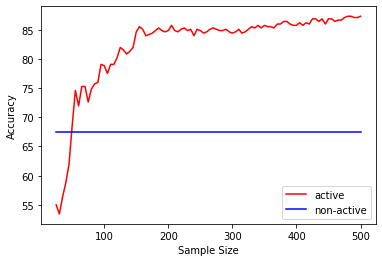

In [251]:
pool_experiment(LogModel,500,25,5)